# Further Study In 2D Multi-element airfoil with Panel Methods
## George Washington University
### MAE6226 Project
### Written by Daiwei Fan

## An Introduction of Panel Methods
### What are panel methods?

Panel methods are techniques for solving incompressible potential flow over thick 2-D and 3-D geometries. In 2-D, the airfoil surface is divided into piecewise straight line segments or panels or “boundary elements” and vortex sheets of strength $\gamma$ are placed on each panel.We use vortex sheets (miniature vortices of strength $\gamma$ds, where ds is the length of a panel) since vortices give rise to circulation, and hence lift.Vortex sheets mimic the boundary layer around airfoils.

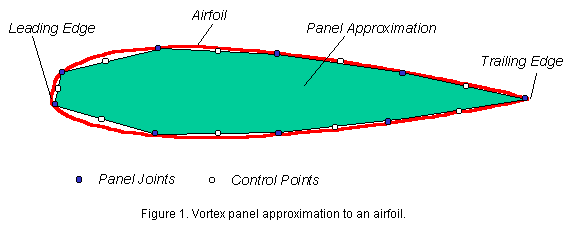

In [1]:
from IPython.core.display import Image 
Image(filename='project1.png')

On each panel, there is vortex sheet of strength $$\Delta\Gamma=\gamma_0ds_0$$
Where ds_0 is the panel length.

Each panel is defined by its two end points (panel joints)
and by the control point, located at the panel center, where we will
Apply the boundary condition 
$$\psi\left(x,y\right)= Constant=C$$
The more the number of panels, the more accurate the solution,
since we are representing a continuous curve by a series 
of broken straight lines


## Theory
Ideal fluid flows are solutions to Laplace's equation. This differential equation is linear, which means that adding together (superposing) any number of ideal flows produces a new ideal flow. One approach to finding the solution to complex flow problems - termed superposition - is therefore to begin with very simple ideal flows, that are easily understood and described, and then to add them together to produce the complex flow patterns desired.

I am going to change correlated variable as flap deflections when a plane have already has a normal level flight attitude. Here, I choose a very nornaml airfoil-airfoil_NACA_61_209.

In [2]:
import os
import math
import numpy
import sympy
from scipy import integrate, linalg
from matplotlib import pyplot
% matplotlib inline
import csv

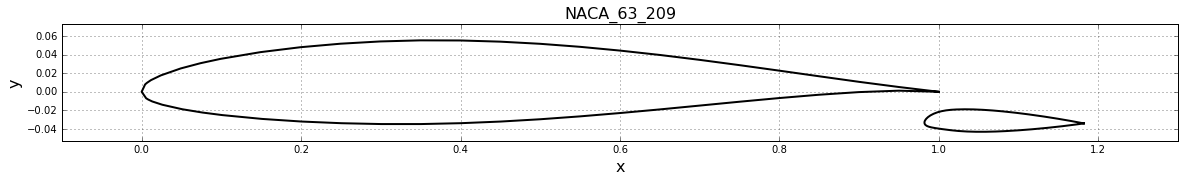

In [3]:
file_name = './FlapFoil.txt'
xf, yf = numpy.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)
#plot the first airfoil NACA_61_209
file_name = './NACA_63_209.txt' 
x1,y1 = numpy.loadtxt(file_name,dtype=float,unpack=True )
val_x1, val_y1 = 0.1, 0.2
x1_min, x1_max = x1.min(), x1.max()
y1_min, y1_max = y1.min(), y1.max()
x1_start, x1_end = x1_min - val_x1*(x1_max - x1_min), x1_max + val_x1*(x1_max - x1_min)
y1_start, y1_end = y1_min - val_y1*(y1_max - y1_min), y1_max + val_y1*(y1_max - y1_min)
size = 20;
pyplot.figure(figsize=(size, (y1_end - y1_start)/(x1_end - x1_start)*size));
pyplot.grid(True)
pyplot.xlabel('x', fontsize = 16)
pyplot.ylabel('y', fontsize = 16)
pyplot.title('NACA_63_209',fontsize = 16)
pyplot.xlim(x1_start, x1_end+0.2)
pyplot.ylim(y1_start, y1_end)
pyplot.plot(xf,yf,color = 'k', linestyle='-', linewidth=2)
pyplot.plot(x1,y1,color = 'k', linestyle='-', linewidth=2)


### now we need define functions to make it rotated

In [4]:
def rotate(xf, yf, xc, yc, angle):
    """
    Rotate airfoil around a point.
    """
    theta = numpy.radians(angle)
    
    x = xf - xc
    y = yf - yc
    
    xp = x*numpy.cos(theta) + y*numpy.sin(theta)
    yp = -x*numpy.sin(theta) + y*numpy.cos(theta)
    
    xn = xp + xc
    yn = yp + yc
    
    return xn, yn

In [5]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center-point, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is located on the upper or lower surface of the geometry.
        Initializes the source-strength, tangential velocity, and pressure coefficient
        of the panel to zero.
        
        Parameters
        ---------_
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya # panel starting-point
        self.xb, self.yb = xb, yb # panel ending-point
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         # panel center
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2) # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper' # upper surface
        else:
            self.loc = 'lower' # lower surface
        
        self.sigma = 0.0 # source strength
        self.vt = 0.0    # tangential velocity
        self.cp = 0.0    # pressure coefficient

In [6]:
def define_panels(x, y):
    """
    Creates panels form discretized geometry.
    
    Parameters
    x: 1D array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    
    Returns
    -------
    panels: 1D numpy array of Panel objects
        The list of panels.
    """
    N = len(x)-1
    x_ends, y_ends = x, y
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
        
    return panels

In [7]:
main_panels = define_panels(x1, y1)
flap_panels = define_panels(xf, yf)
panels = numpy.append(main_panels, flap_panels)

### At here, we just step up flap deflections zero to comparing simpler.

(-0.25, 0.25)

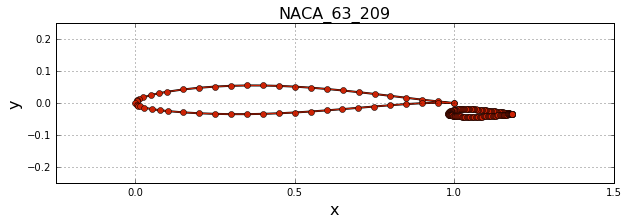

In [8]:
xc, yc = 1.03, -0.054
theta = 0
xf1, yf1 = rotate(xf, yf, xc, yc, theta)
size = 10
pyplot.figure(figsize=(size, size))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(-0.1, 1.25)
pyplot.ylim(-0.35, 0.35)
pyplot.plot(x1, y1, xf1, yf1, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in main_panels], main_panels[0].xa),
            numpy.append([panel.ya for panel in main_panels], main_panels[0].ya),
            numpy.append([panel.xa for panel in flap_panels], flap_panels[0].xa),
            numpy.append([panel.ya for panel in flap_panels], flap_panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305');          
pyplot.axis('scaled', adjustable='box')
pyplot.title('NACA_63_209',fontsize = 16)
pyplot.xlim(-0.25,1.5)
pyplot.ylim(-0.25,0.25)

### Define the equation in Panel Methods

In [9]:
class Freestream:
    def __init__(self, u_inf=1.0, alpha=0.0):
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 # degrees to radians

In [10]:
def integral(x, y, panel, dxdk, dydk):   
    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [11]:
def source_contribution_normal(panels):    
    A = numpy.empty((panels.size, panels.size), dtype=float)    
    numpy.fill_diagonal(A, 0.5)    
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                numpy.cos(panel_i.beta),
                                                numpy.sin(panel_i.beta))
    return A

In [12]:
def vortex_contribution_normal(panels):   
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 numpy.sin(panel_i.beta),
                                                 -numpy.cos(panel_i.beta))
    return A

In [13]:
def build_singularity_matrix(panels, A_source, B_vortex):  
    N = panels.size
    
    # build the tangential velocity contribution matrix
    A_t = numpy.empty((N, N+2), dtype=float)
   
    # matrix of source contribution on tangential velocity
    # is the same as the
    # matrix of vortex contribution on normal velocity
    A_t[:N,:N] = B_vortex
    
    # matrix of vortex contribution on tangential velocity
    # is the opposite of the
    # matrix of source contribution on normal velocity
    A_t_penult, A_t_ult = numpy.zeros((N), dtype=float), numpy.zeros((N), dtype=float)
    for i, panels_i in enumerate(panels):
        A_t_penult[i] = numpy.sum(A_source[i,:int(N/2)])
        A_t_ult[i] = numpy.sum(A_source[i,int(N/2):])
    
    A_t[:, -2] = -A_t_penult
    A_t[:, -1] = -A_t_ult
    
    # build the matrix of the linear system
    A = numpy.empty((N+2, N+2), dtype=float)
    
    # source contribution matrix
    A[:N, :N] = A_source
    
    # vortex contribution array
    A_v = numpy.empty((N,2), dtype=float)
    for i, panel_i in enumerate(panels):
        A_v[i,0] = numpy.sum(B_vortex[i,:int(N/2)])
        A_v[i,1] = numpy.sum(B_vortex[i,int(N/2):])
    
    A[:N, N:] = A_v

    # Kutta condition array
    A_k = numpy.empty((2,N+2), dtype=float)
    A_k[0,:] = A_t[0,:] + A_t[int(N/2-1),:]
    A_k[1,:] = A_t[int(N/2),:] + A_t[-1,:]
    
    A[-2:, :] = A_k
    
    return A

In [14]:
def build_freestream_rhs(panels, freestream):
    N = panels.size
    b = numpy.empty(N+2,dtype=float)
    
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    
    # freestream contribution on the Kutta condition for the main airfoil
    b[-2] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[0].beta)
                               +numpy.sin(freestream.alpha-panels[int(N/2-1)].beta) )
    
    # freestream contribution on the Kutta condition for the flap airfoil
    b[-1] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[int(N/2)].beta)
                               +numpy.sin(freestream.alpha-panels[N-1].beta) )
    
    return b

In [15]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    N = panels.size
    A = numpy.empty((N, N+2), dtype=float)    
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:N,:N] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A_1, A_2 = numpy.zeros((N), dtype=float), numpy.zeros((N), dtype=float)
    for i, panels_i in enumerate(panels):
        A_1[i] = numpy.sum(A_source[i,:int(N/2)])
        A_2[i] = numpy.sum(A_source[i,int(N/2):])
    
    A[:, -2] = -A_1
    A[:, -1] = -A_2
    # freestream contribution
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta 
                                    for panel in panels])
    
    strengths = numpy.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [16]:
def get_pressure_coefficient(panels, freestream):
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [17]:
def compute_pressure_coefficient(panels, freestream):
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

### I choose attack of angle from -15 to 15 degree.

In [18]:
u_inf = 1.0                     
alpha = -15
freestream = Freestream(u_inf, alpha)
N = panels.size
main_panels, flap_panels = panels[:int(N/2)], panels[int(N/2):]
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)
A = build_singularity_matrix(panels, A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)
strengths = numpy.linalg.solve(A, b)
strengths = numpy.linalg.solve(A, b)
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
gamma = strengths[-2:]
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)
compute_pressure_coefficient(panels, freestream)
Lift1, Drag1 = 0.0,0.0
for panel in panels:
    Lift1 -= panel.cp*numpy.sin(panel.beta)*panel.length
    Drag1 += panel.cp*numpy.cos(panel.beta)*panel.length

u_inf = 1.0                     
alpha = -10
freestream = Freestream(u_inf, alpha)
N = panels.size
main_panels, flap_panels = panels[:int(N/2)], panels[int(N/2):]
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)
A = build_singularity_matrix(panels, A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)
strengths = numpy.linalg.solve(A, b)
strengths = numpy.linalg.solve(A, b)
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
gamma = strengths[-2:]
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)
compute_pressure_coefficient(panels, freestream)
Lift2, Drag2 = 0.0,0.0
for panel in panels:
    Lift2 -= panel.cp*numpy.sin(panel.beta)*panel.length
    Drag2 += panel.cp*numpy.cos(panel.beta)*panel.length
    
u_inf = 1.0                      
alpha = -5.0                
freestream = Freestream(u_inf, alpha)
N = panels.size
main_panels, flap_panels = panels[:int(N/2)], panels[int(N/2):]
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)
A = build_singularity_matrix(panels, A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)
strengths = numpy.linalg.solve(A, b)
strengths = numpy.linalg.solve(A, b)
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
gamma = strengths[-2:]
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)
compute_pressure_coefficient(panels, freestream)
Lift3, Drag3 = 0.0,0.0
for panel in panels:
    Lift3 -= panel.cp*numpy.sin(panel.beta)*panel.length
    Drag3 += panel.cp*numpy.cos(panel.beta)*panel.length

u_inf = 1.0                      
alpha = 0.0                
freestream = Freestream(u_inf, alpha)
N = panels.size
main_panels, flap_panels = panels[:int(N/2)], panels[int(N/2):]
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)
A = build_singularity_matrix(panels, A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)
strengths = numpy.linalg.solve(A, b)
strengths = numpy.linalg.solve(A, b)
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
gamma = strengths[-2:]
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)
compute_pressure_coefficient(panels, freestream)
Lift4, Drag4 = 0.0,0.0
for panel in panels:
    Lift4 -= panel.cp*numpy.sin(panel.beta)*panel.length
    Drag4 += panel.cp*numpy.cos(panel.beta)*panel.length

u_inf = 1.0                      
alpha = 5.0                
freestream = Freestream(u_inf, alpha)
N = panels.size
main_panels, flap_panels = panels[:int(N/2)], panels[int(N/2):]
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)
A = build_singularity_matrix(panels, A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)
strengths = numpy.linalg.solve(A, b)
strengths = numpy.linalg.solve(A, b)
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
gamma = strengths[-2:]
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)
compute_pressure_coefficient(panels, freestream)
Lift5, Drag5 = 0.0,0.0
for panel in panels:
    Lift5 -= panel.cp*numpy.sin(panel.beta)*panel.length
    Drag5 += panel.cp*numpy.cos(panel.beta)*panel.length

u_inf = 1.0                      
alpha = 10.0                
freestream = Freestream(u_inf, alpha)
N = panels.size
main_panels, flap_panels = panels[:int(N/2)], panels[int(N/2):]
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)
A = build_singularity_matrix(panels, A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)
strengths = numpy.linalg.solve(A, b)
strengths = numpy.linalg.solve(A, b)
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
gamma = strengths[-2:]
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)
compute_pressure_coefficient(panels, freestream)
Lift6, Drag6 = 0.0,0.0
for panel in panels:
    Lift6 -= panel.cp*numpy.sin(panel.beta)*panel.length
    Drag6 += panel.cp*numpy.cos(panel.beta)*panel.length
    
u_inf = 1.0                      
alpha = 15               
freestream = Freestream(u_inf, alpha)
N = panels.size
main_panels, flap_panels = panels[:int(N/2)], panels[int(N/2):]
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)
A = build_singularity_matrix(panels, A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)
strengths = numpy.linalg.solve(A, b)
strengths = numpy.linalg.solve(A, b)
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
gamma = strengths[-2:]
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)
compute_pressure_coefficient(panels, freestream)
Lift7, Drag7 = 0.0,0.0
for panel in panels:
    Lift7 -= panel.cp*numpy.sin(panel.beta)*panel.length
    Drag7 += panel.cp*numpy.cos(panel.beta)*panel.length

### Experimental data

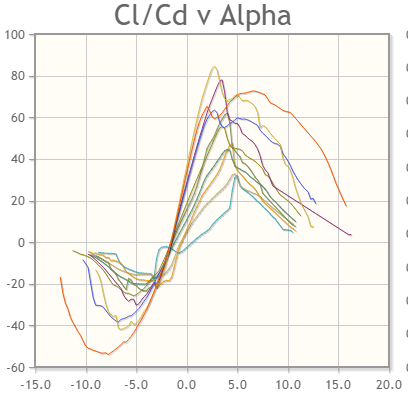

In [19]:
from IPython.core.display import Image 
Image(filename='project4.png')

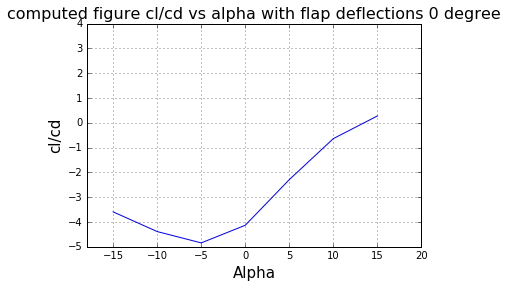

In [20]:
CL_CD1= Lift1/Drag1
CL_CD2= Lift2/Drag2
CL_CD3= Lift3/Drag3
CL_CD4= Lift4/Drag4
CL_CD5= Lift5/Drag5
CL_CD6= Lift6/Drag6
CL_CD7= Lift7/Drag7
size = 20
pyplot.grid(True)
pyplot.xlabel('Alpha', fontsize=15)
pyplot.ylabel('cl/cd', fontsize=15)
pyplot.title('computed figure cl/cd vs alpha with flap deflections 0 degree',fontsize = 16)
pyplot.xlim(-18, 20)
pyplot.ylim(-5, 4)
pyplot.plot([-15,-10,-5,0,5,10,15],[CL_CD1, CL_CD2, CL_CD3, CL_CD4, CL_CD5, CL_CD6, CL_CD7])

### Note:
As we can see, there are some differences between those two figures. Experimental data come from air tools, and I set up NACA 63-209 with Reynolds number from 50,000 to 1000,000 and Number of Critical range from 1 to 12. The tendency in our computed figure of cl/cd versus attack of angle alpha is increasing with alpha when alpha more than five degree and airfoil can get more and more lift when attack angle increases without any continued momentum of decline , but in Experimental data figure, when alpha is five degree, the smallest ratio of cl/cd is almost more than five degree and we can see continued momentum of decline clearly when attack angle more than almost three degree.

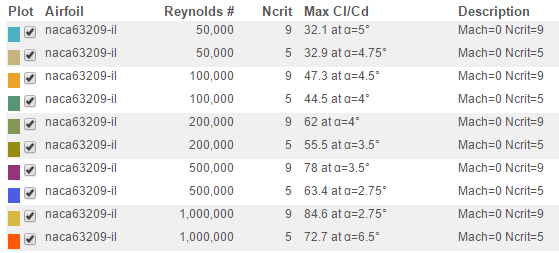

In [21]:
from IPython.core.display import Image 
Image(filename='project6.png')

### Now we change the flap deflections to 20 degree to see what changes can flap bring

(-0.25, 0.25)

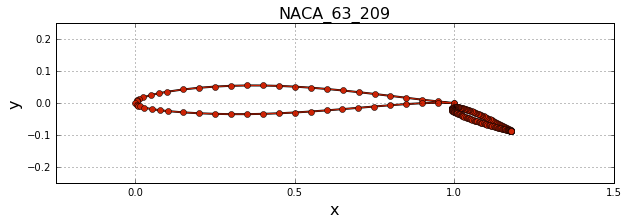

In [22]:
xc, yc = 1.03, -0.054
theta = 20
xf2, yf2 = rotate(xf, yf, xc, yc, theta)

main_panels = define_panels(x1, y1)
flap_panels = define_panels(xf2, yf2)
panels = numpy.append(main_panels, flap_panels)

size = 10
pyplot.figure(figsize=(size, size))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(-0.1, 1.25)
pyplot.ylim(-0.35, 0.35)
pyplot.plot(x1, y1, xf2, yf2, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in main_panels], main_panels[0].xa),
            numpy.append([panel.ya for panel in main_panels], main_panels[0].ya),
            numpy.append([panel.xa for panel in flap_panels], flap_panels[0].xa),
            numpy.append([panel.ya for panel in flap_panels], flap_panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305');          
pyplot.axis('scaled', adjustable='box')
pyplot.title('NACA_63_209',fontsize = 16)
pyplot.xlim(-0.25,1.5)
pyplot.ylim(-0.25,0.25)

In [23]:
u_inf = 1.0                     
alpha = -15
freestream = Freestream(u_inf, alpha)
N = panels.size
main_panels, flap_panels = panels[:int(N/2)], panels[int(N/2):]
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)
A = build_singularity_matrix(panels, A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)
strengths = numpy.linalg.solve(A, b)
strengths = numpy.linalg.solve(A, b)
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
gamma = strengths[-2:]
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)
compute_pressure_coefficient(panels, freestream)
Lift1, Drag1 = 0.0,0.0
for panel in panels:
    Lift1 -= panel.cp*numpy.sin(panel.beta)*panel.length
    Drag1 += panel.cp*numpy.cos(panel.beta)*panel.length

u_inf = 1.0                     
alpha = -10
freestream = Freestream(u_inf, alpha)
N = panels.size
main_panels, flap_panels = panels[:int(N/2)], panels[int(N/2):]
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)
A = build_singularity_matrix(panels, A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)
strengths = numpy.linalg.solve(A, b)
strengths = numpy.linalg.solve(A, b)
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
gamma = strengths[-2:]
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)
compute_pressure_coefficient(panels, freestream)
Lift2, Drag2 = 0.0,0.0
for panel in panels:
    Lift2 -= panel.cp*numpy.sin(panel.beta)*panel.length
    Drag2 += panel.cp*numpy.cos(panel.beta)*panel.length
    
u_inf = 1.0                      
alpha = -5.0                
freestream = Freestream(u_inf, alpha)
N = panels.size
main_panels, flap_panels = panels[:int(N/2)], panels[int(N/2):]
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)
A = build_singularity_matrix(panels, A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)
strengths = numpy.linalg.solve(A, b)
strengths = numpy.linalg.solve(A, b)
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
gamma = strengths[-2:]
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)
compute_pressure_coefficient(panels, freestream)
Lift3, Drag3 = 0.0,0.0
for panel in panels:
    Lift3 -= panel.cp*numpy.sin(panel.beta)*panel.length
    Drag3 += panel.cp*numpy.cos(panel.beta)*panel.length

u_inf = 1.0                      
alpha = 0.0                
freestream = Freestream(u_inf, alpha)
N = panels.size
main_panels, flap_panels = panels[:int(N/2)], panels[int(N/2):]
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)
A = build_singularity_matrix(panels, A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)
strengths = numpy.linalg.solve(A, b)
strengths = numpy.linalg.solve(A, b)
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
gamma = strengths[-2:]
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)
compute_pressure_coefficient(panels, freestream)
Lift4, Drag4 = 0.0,0.0
for panel in panels:
    Lift4 -= panel.cp*numpy.sin(panel.beta)*panel.length
    Drag4 += panel.cp*numpy.cos(panel.beta)*panel.length

u_inf = 1.0                      
alpha = 5.0                
freestream = Freestream(u_inf, alpha)
N = panels.size
main_panels, flap_panels = panels[:int(N/2)], panels[int(N/2):]
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)
A = build_singularity_matrix(panels, A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)
strengths = numpy.linalg.solve(A, b)
strengths = numpy.linalg.solve(A, b)
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
gamma = strengths[-2:]
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)
compute_pressure_coefficient(panels, freestream)
Lift5, Drag5 = 0.0,0.0
for panel in panels:
    Lift5 -= panel.cp*numpy.sin(panel.beta)*panel.length
    Drag5 += panel.cp*numpy.cos(panel.beta)*panel.length

u_inf = 1.0                      
alpha = 10.0                
freestream = Freestream(u_inf, alpha)
N = panels.size
main_panels, flap_panels = panels[:int(N/2)], panels[int(N/2):]
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)
A = build_singularity_matrix(panels, A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)
strengths = numpy.linalg.solve(A, b)
strengths = numpy.linalg.solve(A, b)
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
gamma = strengths[-2:]
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)
compute_pressure_coefficient(panels, freestream)
Lift6, Drag6 = 0.0,0.0
for panel in panels:
    Lift6 -= panel.cp*numpy.sin(panel.beta)*panel.length
    Drag6 += panel.cp*numpy.cos(panel.beta)*panel.length
    
u_inf = 1.0                      
alpha = 15               
freestream = Freestream(u_inf, alpha)
N = panels.size
main_panels, flap_panels = panels[:int(N/2)], panels[int(N/2):]
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)
A = build_singularity_matrix(panels, A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)
strengths = numpy.linalg.solve(A, b)
strengths = numpy.linalg.solve(A, b)
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
gamma = strengths[-2:]
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)
compute_pressure_coefficient(panels, freestream)
Lift7, Drag7 = 0.0,0.0
for panel in panels:
    Lift7 -= panel.cp*numpy.sin(panel.beta)*panel.length
    Drag7 += panel.cp*numpy.cos(panel.beta)*panel.length

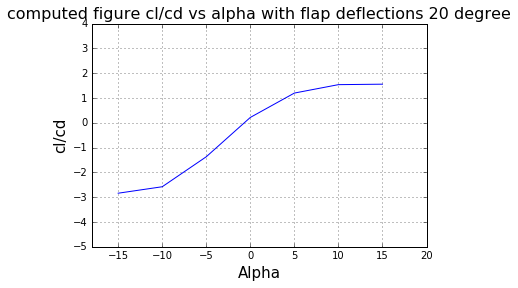

In [24]:
CL_CD1= Lift1/Drag1
CL_CD2= Lift2/Drag2
CL_CD3= Lift3/Drag3
CL_CD4= Lift4/Drag4
CL_CD5= Lift5/Drag5
CL_CD6= Lift6/Drag6
CL_CD7= Lift7/Drag7
size = 20
pyplot.grid(True)
pyplot.xlabel('Alpha', fontsize=15)
pyplot.ylabel('cl/cd', fontsize=15)
pyplot.title('computed figure cl/cd vs alpha with flap deflections 20 degree',fontsize = 16)
pyplot.xlim(-18, 20)
pyplot.ylim(-5, 4)
pyplot.plot([-15,-10,-5,0,5,10,15],[CL_CD1, CL_CD2, CL_CD3, CL_CD4, CL_CD5, CL_CD6, CL_CD7])

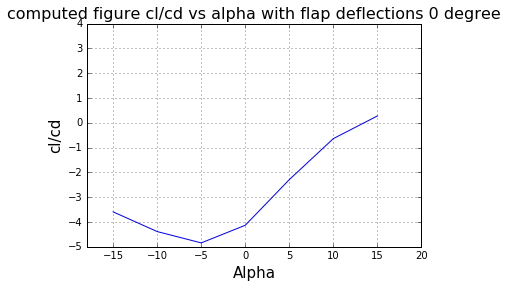

In [25]:
from IPython.core.display import Image 
Image(filename='project7.png')

### Note:
The maximum ratio of Cl/Cd with flap deflections 20 degree approaches to 1.53, but in without any deflections, the maximum ratio of Cl/Cd approaches to 0.3. The minimum ratio of Cl/Cd with flap deflections 20 degree approaches to 0.3, but in without any deflections, the minimum ratio of Cl/Cd approaches to -4.8.

## conclusion:
From the former's research，we know our panel method has a lot of limitation such as huge system error when we solve for low Renoylds number airfloil. So in my project i am going to use airfloil in high Renoylds number.

Panel methods are ideal for concept design analysis due to their rapid turnaround time and relatively easy surface modeling, but this is countered by their inability to predict boundary layers and flow separation. The lack of viscosity modeling in a panel method leads to another limitation: they can’t model rotational flows such as that found in a cyclone. Panel methods can’t model supersonic flow (Mach number > 1) either. When you consider that the majority of fluid flows relevant to engineers are subsonic, the inability to model supersonic flows is a minor constraint compared to the lack of viscosity modeling.

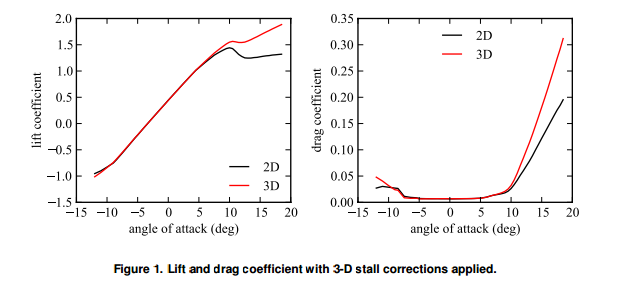

In [26]:
from IPython.core.display import Image 
Image(filename='project2.png')

When velocity of aircraft is very fast, the ratio of Cl/Cd will decrease normally. The higher ratio of Cl/Cd means better aerodynamic performance, it is important to fly and climb. But it occurs stalled when the critical angle of attack of the foil is exceeded. The critical angle of attack is typically about 15 degrees, but it may vary significantly depending on the fluid, foil, and Reynolds number. A stall does not mean that the engines have stopped working, or that the aircraft has stopped moving, the effect is the same even in an unpowered glider aircraft.

Increasing flap deflections during provides several advantages by:
a)Producing greater lift and permitting lower landing speed or take off speed.
b)Producing greater drag when landing, permitting a steep descent angle without airspeed increase.
c)Reducing the length of the landing roll. 

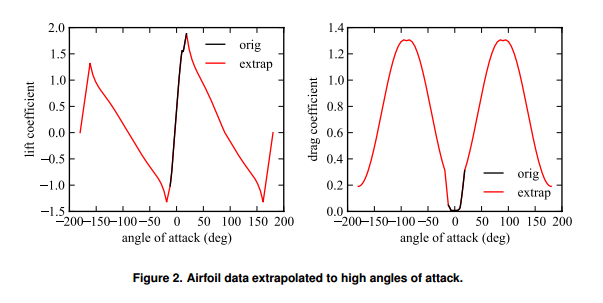

In [27]:
from IPython.core.display import Image 
Image(filename='project3.png')

## Refrences: 
$$[1] http://m-selig.ae.illinois.edu/ads/coord_database.html$$
$$[2] http://www.symscape.com/blog/why_use_panel_method$$
$$[3]http://www.engapplets.vt.edu/fluids/vpm/vpminfo.html$$
$$[4]https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19910009745.pdf$$
$$[5]https://www.grc.nasa.gov/www/k-12/airplane/ldrat.html$$
$$[6]https://www.faasafety.gov/files/gslac/courses/content/35/376/Use%20of%20Flaps.pdf$$